In [1]:
import numpy as np

from Analysis_utils import *
from Plots import *
from scipy.interpolate import CubicSpline

# 3D Embedding

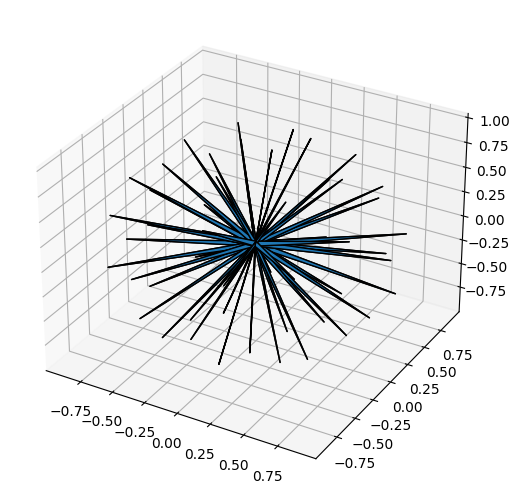

In [2]:
m = Manifold(100)
plot_triangulation_3d(m.adj)

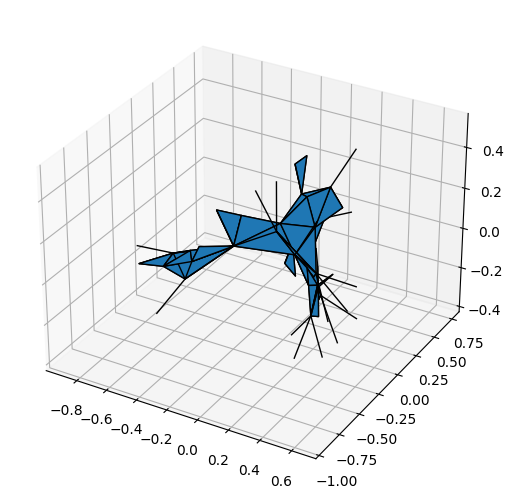

In [3]:
n_sweeps = 20
m.sweep(n_sweeps, 0.1, strategy=['gravity', 'spinor'])
plot_triangulation_3d(m.adj)

In [4]:
%time m.sweep(n_sweeps, 0.1, strategy=['gravity', 'spinor'])

CPU times: user 13.7 s, sys: 9.47 ms, total: 13.8 s
Wall time: 13.8 s


In [5]:
%time m.sweep(n_sweeps, 0.1, strategy=['gravity', 'spinor'], fast=True)

CPU times: user 7.4 s, sys: 0 ns, total: 7.4 s
Wall time: 7.41 s


In [10]:
%time m.sweep(n_sweeps, 0.1, strategy=['gravity'], fast=True)
%time m.sweep(n_sweeps, 0.1, strategy=['gravity'])

CPU times: user 90.5 ms, sys: 6 µs, total: 90.5 ms
Wall time: 91 ms
CPU times: user 6.23 s, sys: 3.28 ms, total: 6.24 s
Wall time: 6.25 s


In [8]:
is_sphere_triangulation(m.adj)

True

# Distance Profile and Haussdorff Dimension (pure gravity)

In [9]:
beta=0
sizes = np.array([2*int(i) for i in np.geomspace(10, 20, 3)])
profiles = make_profiles(beta, sizes, strategy=['gravity'])
plot_profiles(profiles, sizes)

KeyboardInterrupt: 

In [ ]:
d_Haussdorf = 4
xs, ys = scale_profile(profiles, sizes, 1/d_Haussdorf)
overlay_profiles(ys, xs, sizes)

# Finite size scaling

In [ ]:
def scale_profile(profiles, sizes, d):
    xs, ys = [], []
    for i, profile in enumerate(profiles):
        rvals = np.arange(len(profile))
        x = rvals / sizes[i] ** d
        y = profile / sizes[i] ** (1 - d)
        xs.append(x), ys.append(y)
        # plt.plot(x, y)
    return np.array(xs), np.array(ys)

def profiles_max(profiles):
    profiles_max = np.max(profiles, axis=1)
    return profiles_max[:,0], profiles_max[:,1]

def power_fit(N, d, a):
    return a*N**d

def lin_fit(x, d, b):
    return b + d*x

def finite_size_scaling(profile, sizes):
    prof_max, sigma_max = profiles_max(profile)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

def finite_size_scaling_fit(profile, sizes):
    prof_max = np.max(profile, axis=1)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

In [ ]:
beta=0.65
sizes = [(int(i)//2)*2 for i in np.geomspace(50, 500, 6)]

prof = make_profiles(beta, sizes, meas_sweeps=10, strategy=['gravity'])


prof_0 = prof[..., 0]
rs0 = np.arange
rs = np.arange(0.1, 10, 0.05)
fit_prof = []


fig, ax = plt.subplots(2)
for profile in prof_0:
    dist_range = range(len(profile))
    cs = CubicSpline(dist_range, profile)
    fit_prof.append(cs(rs))
    ax[0].plot(dist_range, profile)

for p in fit_prof:
    ax[0].plot(rs, p)

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)
ax[1].plot(x, y, 'go-')

np.savez('profiles_spinor', full_prof=prof, fit_prof=np.array(fit_prof), prof_0=prof_0, sizes=sizes, beta=beta)

In [ ]:
sizes = np.load('profiles_spinor.npz')['sizes']
fit_prof = np.load('profiles_beta_1.npz')['fit_prof']
prof = np.load('profiles_beta_1.npz')['full_prof']

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)

fit = curve_fit(lin_fit, x, y, p0=[0.75, 0])
(d, a), err = fit
d_H = 1/(1-d)
d_err = np.sqrt(err[0,0])
d_H_err = d_H**2*d_err
a_err = np.sqrt(err[1,1])

print("\nwith spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

d_H, d_H_err, a, a_err = finite_size_scaling(prof, sizes)
print("\nwithout spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

In [ ]:
# CHECK ACCEPTANCE RATE OF ISING MOVES.
# RESCALE SPLINES SO THAT THEY HAVE SAME SIZE


steps = 50
n_plots = 4
fig, ax = plt.subplots(n_plots+1)

s = slice(0, None)
prof = np.load('profiles_beta_1.npz')['full_prof'][s]

ds = np.linspace(3, 5, steps)
x_range = np.arange(0.5, 1.5, 0.05)
errors = []
min_err = np.inf
min_d = 0
for i, d in enumerate(ds):
    splines = []
    xs, ys = scale_profile(prof, sizes, 1/d)
    ys = ys[..., 0]
    for x, y in zip(xs, ys):
        cs = CubicSpline(x, y)
        splines.append(cs(x_range))

        interval = int(np.ceil(steps/n_plots))
        if i%interval==0:
            ax[i//interval].plot(x_range, cs(x_range))

    splines = np.array(splines)
    err_spline = np.sum(np.var(splines, axis=0))
    if err_spline < min_err:
        min_err = err_spline
        min_d = d
    errors.append(err_spline)


print(f'{min_d = }')
print(f'{min_err = }')
ax[-1].plot(ds, errors)

In [ ]:
sizes = [(int(i)//2)*2 for i in np.geomspace(100, 1000, 10)]
fit_prof = np.load('profiles_beta_1.npz')['fit_prof']
prof = np.load('profiles_beta_1.npz')['full_prof']
xs, ys = scale_profile(prof, sizes, 1/4)

In [ ]:
d = 3.5
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs, sizes)

In [ ]:
d = 4
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs, sizes)